<a href="https://colab.research.google.com/github/YolandaMDavis/wildtrack-iqa/blob/additional-tuning/task_amenability_species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym==0.17.3;
!pip install stable-baselines==2.10.2;
!pip install h5py==3.0.0;
!pip install tensorflow==1.13.1;
!pip install tensorboard==1.13.1;
!pip install Keras==2.2.4;
!pip install Keras-Applications==1.0.8;
!pip install Keras-Preprocessing==1.1.2;
!pip install keras-rl==0.4.2;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Only needed to copy data to local drive can be skipped if zip file is already available in working folder
import shutil

# mount google drive
from google.colab import drive
drive.mount('/content/drive') # for google colab. adjust accordingly
PARENT_DIR = '/content/drive/MyDrive/Wildtrack Group/IQA' 

# copy and extract tar file
shutil.copy(PARENT_DIR + '/data/Annotated_Cropped_WildTrack.zip', 'Cropped_WildTrack.zip')

# get downstream task model
shutil.copy(PARENT_DIR + '/task-amenability/species/model.pt', 'species_model.pt')

shutil.copy(PARENT_DIR + '/task-amenability/object/model.pt', 'object_model.pt')


Mounted at /content/drive


'object_model.pt'

In [ ]:
# clone the repository and move data file
!git clone https://github.com/YolandaMDavis/wildtrack-iqa.git
!mv Cropped_WildTrack.zip wildtrack-iqa/.
!mv species_model.pt wildtrack-iqa/.
!mv object_model.pt wildtrack-iqa/.
%cd "wildtrack-iqa"
#!git checkout task-amenability
!mv species_model.pt taskamenability/taskpredictor/species/model.pt
!mv object_model.pt taskamenability/taskpredictor/objdet/model.pt


Cloning into 'wildtrack-iqa'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 174 (delta 39), reused 56 (delta 36), pack-reused 110
Receiving objects: 100% (174/174), 1.73 MiB | 23.66 MiB/s, done.
Resolving deltas: 100% (69/69), done.
/content/wildtrack-iqa


In [ ]:
from zipfile import ZipFile
# extract zip file
with ZipFile('Cropped_WildTrack.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [ ]:
%cd "wildtrack-iqa"

import torch
import torchvision
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import json
import numpy as np
import albumentations as A

with open('taskamenability/taskpredictor/species/class_mapping.json') as data:
    mappings = json.load(data)

class_mapping = {item['model_idx']: item['class_name'] for item in mappings}
device = torch.device('cpu')
model = torch.jit.load('taskamenability/taskpredictor/species/model.pt').to(device)
transforms = A.load('taskamenability/taskpredictor/species/transforms.json')

/content/wildtrack-iqa


In [ ]:
from torch.utils import data
import csv
import random
import torch
import yaml
import cv2
import os

from time import process_time
from torch.utils.data import Dataset

root_dir = '/content/wildtrack-iqa'
data_dir = root_dir + '/RAW'

def get_key(val, item_dict):
    for key, value in item_dict.items():
        if val == value:
            return key
    return -1

def oversample_images(image_reference_list):
  performance = []
  for image_ref in image_reference_list:
    image_name = image_ref[0]+'/'+image_ref[3]
    image = convert_image(image_name)
    image = torch.from_numpy(image).to(device)
    obs = image.permute(2, 0, 1).unsqueeze(dim=0).float()
    y_pred = model(obs)
    y_pred = y_pred.argmax(dim=1).squeeze().item()
    performance.append(1 if y_pred == image_ref[4] else 0)

  print("Image Count Before Over Sampling " + str(len(image_reference_list)))
  performance = np.array(performance)
  matching = performance == 1
  non_matching = performance == 0
  non_matching_image_reference_list = np.array(image_reference_list)[non_matching]
  matching_image_reference_list = np.array(image_reference_list)[matching]

  if len(non_matching_image_reference_list) < len(matching_image_reference_list):
    diff = len(matching_image_reference_list) - len(non_matching_image_reference_list) 
    for i in range(diff):
      sample_idx = random.randint(0, len(non_matching_image_reference_list) - 1)
      item = tuple(int(i) if i.isdigit() else i for i in tuple(non_matching_image_reference_list[sample_idx])) 
      image_reference_list.append(item)	

  print("Image Count After Over Sampling " + str(len(image_reference_list)))
  return image_reference_list

def generate_data_sets(sample_percentage=1, oversample=True):

    image_reference_list = []
    subdirectories = list(os.walk(data_dir, topdown=False))[:-1]

    for subdir in subdirectories:
        image_location = subdir[0]
        images = subdir[2]
        species_rating = image_location.rsplit('/', 1)[-1].replace('_', ' ')
        subjective_score = int(species_rating.rsplit(' ', 1)[-1])
        species_class = species_rating.rsplit(' ', 1)[:-1][0]
        if len(species_class.rsplit(' ', 1)) > 1:
            species = species_class.rsplit(' ')[0]
            animal_class = ' '.join(species_class.rsplit(' ')[1:])
        else:
            animal_class = 'Unknown'
            species = species_class

        for image in images:
            class_name = species if animal_class == 'Unknown' else species + ': ' + animal_class
            class_index = get_key(class_name, class_mapping)
            if class_index > -1:
              image_reference = (image_location, species, animal_class, image, class_index, subjective_score)
              image_reference_list.append(image_reference)
    
    if oversample:
      # oversample minority(low performing) images
      image_reference_list = oversample_images(image_reference_list)
  

    # shuffle then split
    seed = 1234
    random.Random(seed).shuffle(image_reference_list)

    train_index = int(len(image_reference_list) * 0.6 * sample_percentage)
    test_index = -int(len(image_reference_list) * 0.2 * sample_percentage) 
    val_index = test_index * 2

    training = image_reference_list[:train_index]
    validation = image_reference_list[val_index:test_index]
    testing = image_reference_list[test_index:]
    return training, validation, testing

def convert_image(img_test):
    image = Image.open(img_test)
    #convert bw to RGB
    bands = image.getbands()
    #image = image.convert('1') 
    if len(bands) == 1:
      image = image.convert(mode='RGB')
    image = np.array(image)
    image = transforms(image=image)['image']
    #x = torch.from_numpy(image).to(device)
    return image


def transform_images(images):
  x = []
  y = []
  for img in images:
      image_name = img[0]+'/'+img[3]
      image = convert_image(image_name)
      x.append(image)
      y.append(img[4])

  return np.array(x), np.array(y)


In [ ]:
# take a percentage of the full data set as a training/test/validation sample
sample_size=1
train, valid, test = generate_data_sets(sample_size, False)
x_train, y_train = transform_images(train)
x_val, y_val = transform_images(valid)
x_test, y_test = transform_images(test)

**Execute the below installation only in Colab environment**

In [ ]:
from taskamenability.interface import DDPGInterface, PPOInterface

img_shape = (512,512,3)
task_predictor = model
interface = PPOInterface(x_train, y_train, x_val, y_val, x_test, y_test, task_predictor, img_shape)

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

init vecmonitor:  tmp/
init resultswriter


Instructions for updating:
Use tf.cast instead.


In [ ]:
interface.train(200)

Training started for 200 episodes:
0.6074074074074074
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6074074074074074]
Reward: 0.6074074074074074
Num timesteps: 64
Best mean reward: -inf - Last mean reward per episode: 0.61
Saving new best model to tmp/best_model
--------------------------------------
| approxkl           | 2.1250621e+33 |
| clipfrac           | 0.75          |
| ep_len_mean        | 64            |
| ep_reward_mean     | 0.6074074     |
| explained_variance | -5.26         |
| fps                | 2             |
| n_updates          | 1             |
| policy_entropy     | 2.1188748     |
| policy_loss        | 0.24772815    |
| serial_timesteps   | 64            |
| time_elapsed       | 2.07e-05      |
| total_timesteps    | 64            |
| value_loss         | 9.785391e+16  |
--------------------------------------
0.5
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6074074074074074, -1]
Reward: -1
Num timesteps: 128
Best mean reward: 0.61 - Last mean reward

In [ ]:
import shutil

# copy best model to share
shutil.copy('tmp/best_model.zip', '/content/drive/MyDrive/Wildtrack Group/IQA/task-amenability/best_model.zip')
interface.load('tmp/best_model.zip')
#shutil.copy('/content/drive/MyDrive/Wildtrack Group/IQA/task-amenability/best_model_10_28_2022.zip','tmp/best_model.zip', )
#interface.load('tmp/best_model.zip')

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [ ]:
preds = []
class_preds = []
for item in x_test:
  item = torch.from_numpy(item).to(device)
  obs = item.permute(2, 0, 1).unsqueeze(dim=0).float()
  y_pred = model(obs)
  y_pred = y_pred.argmax(dim=1).squeeze().item()
  class_preds.append(y_pred)
  preds.append(interface.model.predict(item)[0])

preds = np.rint(np.array(preds).flatten())

In [ ]:
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, precision_score, recall_score

class_actuals = [ item[4] for item in test]

performance_actual =  [1 if class_preds[i] == class_actuals[i] else 0 for i in range(len(class_preds))]

print(balanced_accuracy_score(performance_actual, preds))
print(classification_report(performance_actual, preds))

0.5292348714910007
              precision    recall  f1-score   support

           0       0.18      0.44      0.26       115
           1       0.85      0.61      0.71       587

    accuracy                           0.59       702
   macro avg       0.52      0.53      0.49       702
weighted avg       0.74      0.59      0.64       702



In [ ]:
subjective_quality = [ 1 if item[5] >= 4 else 0 for item in test]
print(balanced_accuracy_score(performance_actual, subjective_quality))
print(classification_report(performance_actual, subjective_quality))

0.5100140730316273
              precision    recall  f1-score   support

           0       0.17      0.31      0.22       115
           1       0.84      0.71      0.77       587

    accuracy                           0.64       702
   macro avg       0.51      0.51      0.50       702
weighted avg       0.73      0.64      0.68       702



In [ ]:
# percentage where quality assessment matched the actual outcome (i.e. if deemed 1 it could truly be classified, if deemed 0 it could not be classified)
class_actuals = [ item[4] for item in test]
subjective_quality = [ item[5] for item in test]

accurate_quality_assessment = []
for i in range(len(class_preds)):
  pred_value = preds[i]
  if class_preds[i] == class_actuals[i] and pred_value == 1:
    accurate_quality_assessment.append(1)
  elif class_preds[i] != class_actuals[i] and pred_value == 0:
    accurate_quality_assessment.append(1)
  else:
    accurate_quality_assessment.append(0)

overall_percentage_correct = np.mean(np.array(accurate_quality_assessment)) * 100
overall_percentage_correct

58.68945868945868

In [ ]:
# how well does subjective scores do in predicting what images should be used vs not used?
subjective_quality_assessment = []

for i in range(len(class_preds)):
  if class_preds[i] == class_actuals[i] and subjective_quality[i] >= 4:
    subjective_quality_assessment.append(1)
  elif class_preds[i] != class_actuals[i] and subjective_quality[i] < 4:
    subjective_quality_assessment.append(1)
  else:
    subjective_quality_assessment.append(0)

subjective_percentage_correct = np.mean(np.array(subjective_quality_assessment)) * 100
subjective_percentage_correct

64.24501424501425

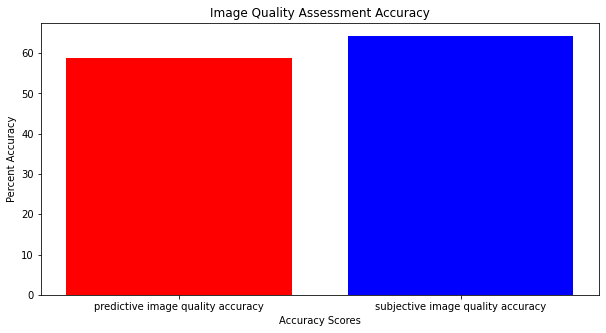

In [ ]:
# creating the dataset
data = {'predictive image quality accuracy':overall_percentage_correct, 'subjective image quality accuracy': subjective_percentage_correct}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color = ['red', 'blue'])
 
plt.xlabel("Accuracy Scores")
plt.ylabel("Percent Accuracy")
plt.title("Image Quality Assessment Accuracy")
plt.show()

In [ ]:
# out of the total number predicted as high quality, how many actually are high quality? (precision)

matching_quality_assessment = []
for i in range(len(class_preds)):
  pred_value = preds[i]
  if class_preds[i] == class_actuals[i] and pred_value == 1:
    matching_quality_assessment.append(1)
  elif class_preds[i] != class_actuals[i] and pred_value == 1:
    matching_quality_assessment.append(0)
  else:
    matching_quality_assessment.append(-1)

matching_percentage_correct = np.mean(np.array([value for value in matching_quality_assessment if (value == 0 or value == 1) ])) * 100
matching_percentage_correct


84.94117647058823

In [ ]:
# out of the total number predicted as low quality, what percentage are  actually low quality? (recall)
non_matching_quality_assessment = []

for i in range(len(class_preds)):
  pred_value = preds[i]
  if class_preds[i] != class_actuals[i] and pred_value == 0:
    non_matching_quality_assessment.append(1)
  elif class_preds[i] == class_actuals[i] and pred_value == 0:
    non_matching_quality_assessment.append(0)
  else:
    non_matching_quality_assessment.append(-1)

non_matching_percentage_correct = np.mean(np.array([value for value in non_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
non_matching_percentage_correct

18.4115523465704

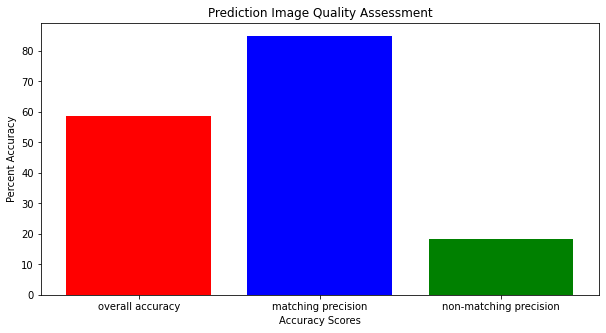

In [ ]:
# creating the dataset
data = {'overall accuracy':overall_percentage_correct, 'matching precision':matching_percentage_correct, 'non-matching precision':non_matching_percentage_correct}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color = ['red', 'blue','green'])
 
plt.xlabel("Accuracy Scores")
plt.ylabel("Percent Accuracy")
plt.title("Prediction Image Quality Assessment")
plt.show()

In [ ]:
# how well are we doing when predicting classes that truly matched? (precision)

subj_matching_quality_assessment = []

for i in range(len(class_preds)):
  if class_preds[i] == class_actuals[i] and subjective_quality[i] >= 4:
    subj_matching_quality_assessment.append(1)
  elif class_preds[i] != class_actuals[i] and subjective_quality[i] >= 4:
    subj_matching_quality_assessment.append(0)
  else:
    subj_matching_quality_assessment.append(-1)

subj_matching_percentage_correct = np.mean(np.array([value for value in subj_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
subj_matching_percentage_correct

84.0080971659919

In [ ]:
# how well are we doing when predicting when not to use an image ? (recall)
subj_non_matching_quality_assessment = []

for i in range(len(class_preds)):

  if class_preds[i] != class_actuals[i] and subjective_quality[i] < 4:
    subj_non_matching_quality_assessment.append(1)
  elif class_preds[i] == class_actuals[i] and subjective_quality[i] < 4:
    subj_non_matching_quality_assessment.append(0)
  else:
    subj_non_matching_quality_assessment.append(-1)

subj_non_matching_percentage_correct = np.mean(np.array([value for value in subj_non_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
subj_non_matching_percentage_correct

17.307692307692307

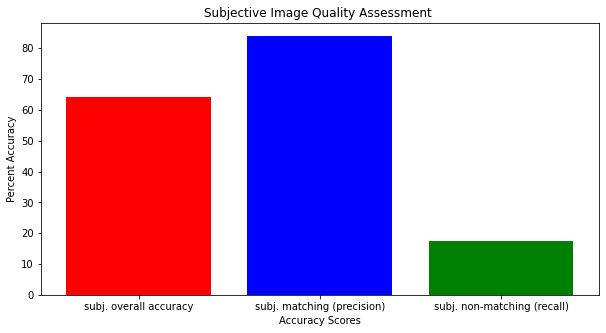

In [ ]:
# creating the dataset
data = {'subj. overall accuracy':subjective_percentage_correct, 'subj. matching (precision)': subj_matching_percentage_correct, 'subj. non-matching (recall)': subj_non_matching_percentage_correct}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color = ['red', 'blue','green'])
 
plt.xlabel("Accuracy Scores")
plt.ylabel("Percent Accuracy")
plt.title("Subjective Image Quality Assessment ")
plt.show()

Let's breakdown by species performance

In [ ]:
import pandas as pd

overall_species = []
for i in range(len(class_actuals)):
  actual_quality = 1 if class_preds[i] == class_actuals[i] else 0
  subj_quality = 1 if subjective_quality[i] >= 4 else 0
  class_name = class_mapping[class_actuals[i]]
  overall_species.append((class_name, int(preds[i]), subj_quality, actual_quality))

species_accuracy = pd.DataFrame(overall_species, columns =['species', 'predicted_quality', 'subjective_quality', 'actual_performance'])


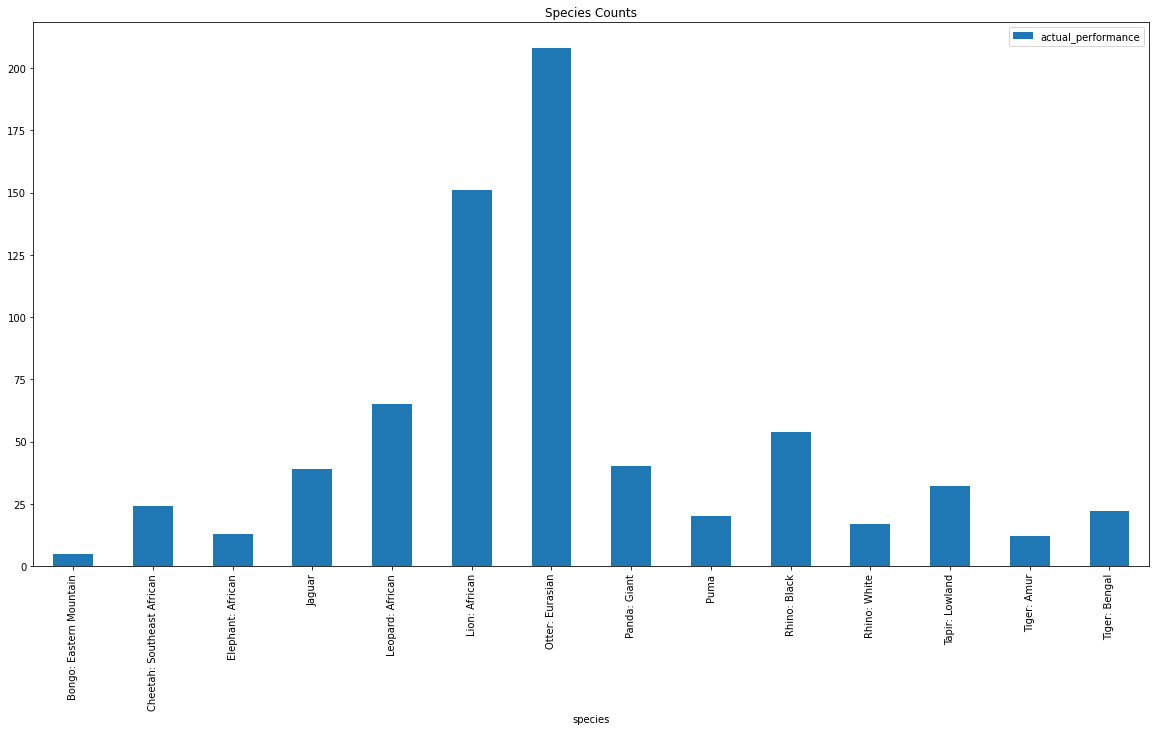

In [ ]:
# figure out data distributiong

species_dist = species_accuracy[['species','actual_performance']].groupby(['species']).count()

species_dist.plot(kind = 'bar', figsize=(20,10))
plt.title('Species Counts')
plt.show()

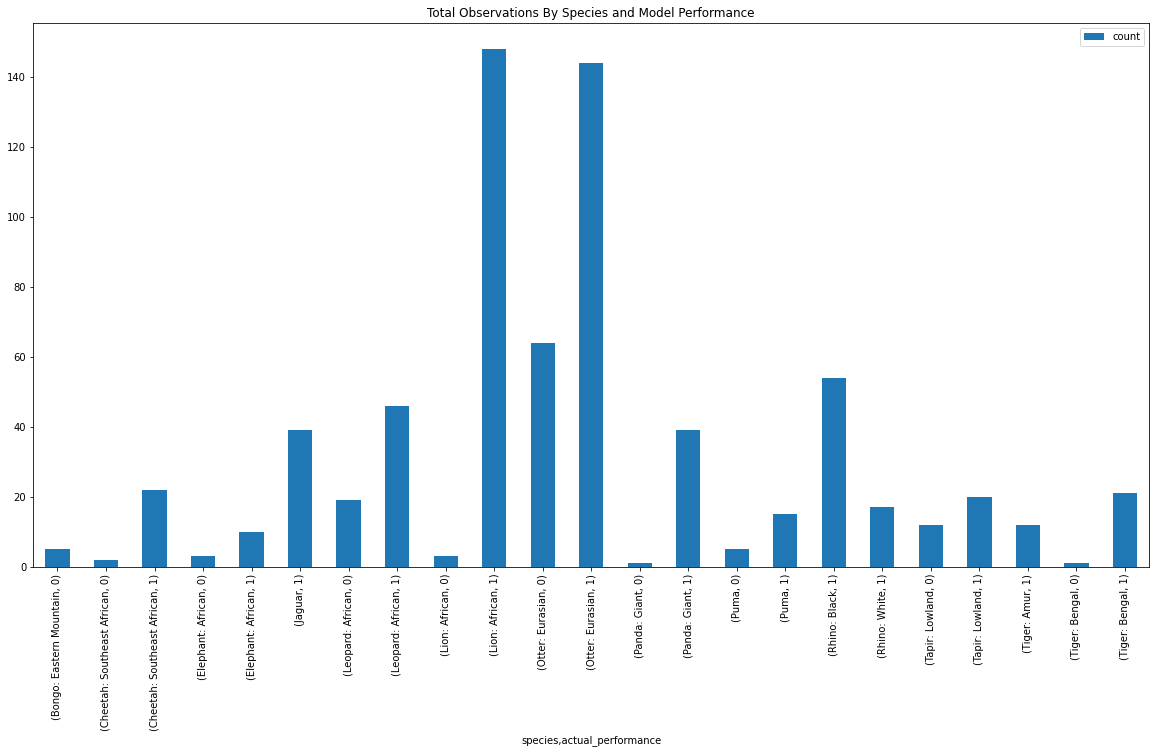

In [ ]:
species_accuracy[['species','actual_performance','predicted_quality']].rename(columns={"predicted_quality": "count"}).groupby(['species','actual_performance']).count().plot(kind = 'bar', figsize=(20,10))
plt.title('Total Observations By Species and Model Performance')
plt.show()

In [ ]:
species_accuracy['prediction_correct'] = species_accuracy['predicted_quality'] == species_accuracy['actual_performance'] 
species_accuracy['prediction_correct'] = species_accuracy['prediction_correct'].astype(int)

species_accuracy['subjective_correct'] = species_accuracy['subjective_quality'] == species_accuracy['actual_performance']
species_accuracy['subjective_correct'] = species_accuracy['subjective_correct'].astype(int)

species_accuracy['prediction_incorrect'] = species_accuracy['predicted_quality'] != species_accuracy['actual_performance'] 
species_accuracy['prediction_incorrect'] = species_accuracy['prediction_incorrect'].astype(int)

species_accuracy['subjective_incorrect'] = species_accuracy['subjective_quality'] != species_accuracy['actual_performance']
species_accuracy['subjective_incorrect'] = species_accuracy['subjective_incorrect'].astype(int)


In [ ]:
subj_overall_accuracy_by_species = species_accuracy[['species','subjective_correct','subjective_incorrect']].groupby(['species']).sum()
pred_overall_accuracy_by_species = species_accuracy[['species','prediction_correct','prediction_incorrect']].groupby(['species']).sum()


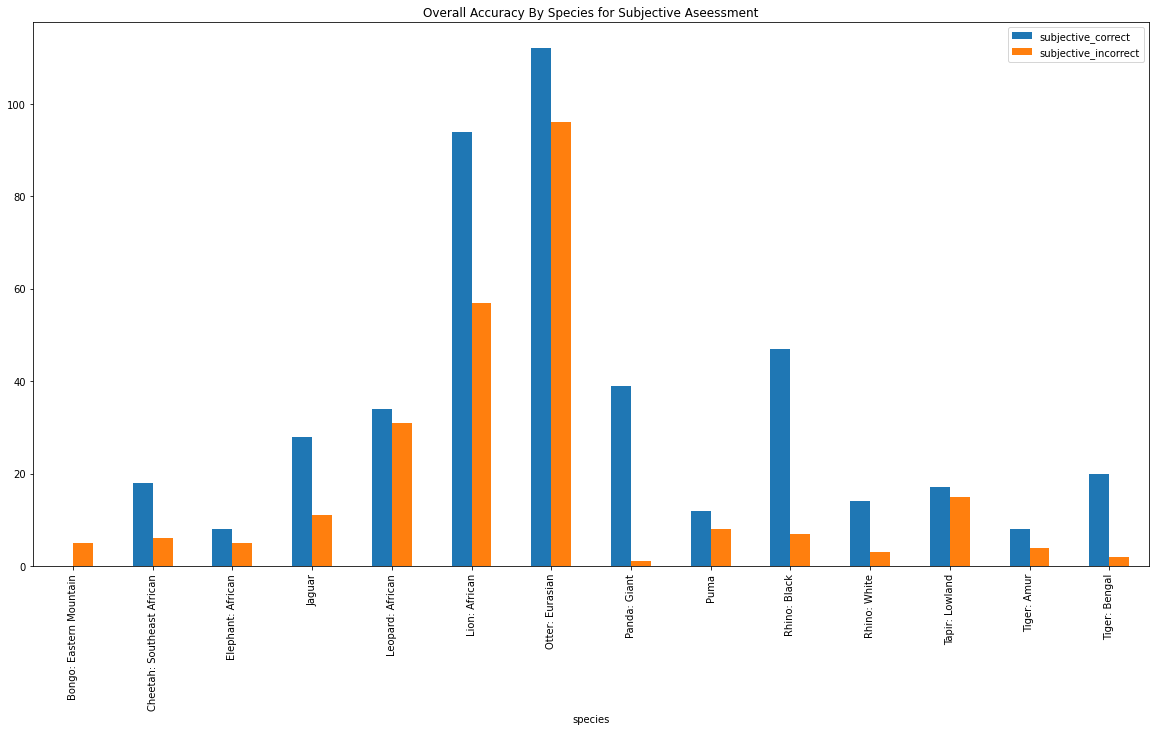

In [ ]:
subj_overall_accuracy_by_species.plot(kind = 'bar', figsize=(20,10))
plt.title('Overall Accuracy By Species for Subjective Aseessment')
plt.show()

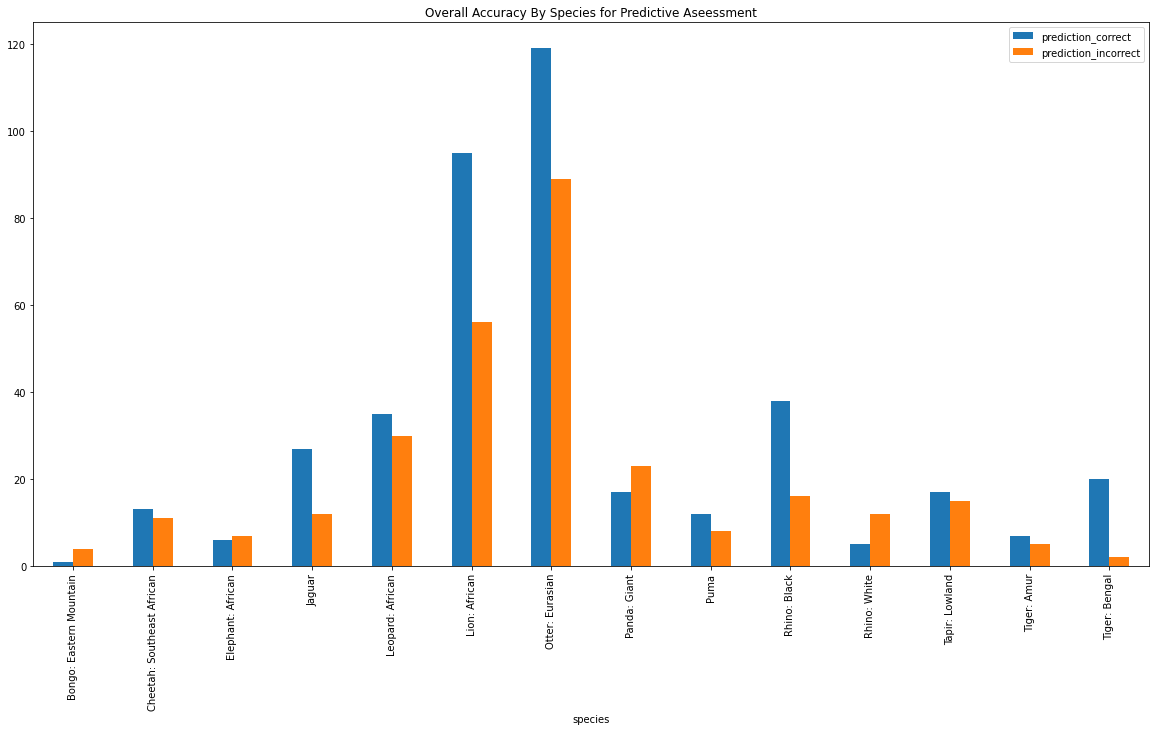

In [ ]:
pred_overall_accuracy_by_species.plot(kind = 'bar', figsize=(20,10))
plt.title('Overall Accuracy By Species for Predictive Aseessment')
plt.show()

In [ ]:
subj_accuracy_by_species_and_actual_perf = species_accuracy[['species','actual_performance','subjective_correct','subjective_incorrect']].groupby(['species','actual_performance']).sum()
pred_accuracy_by_species_and_actual_perf = species_accuracy[['species','actual_performance','prediction_correct','prediction_incorrect']].groupby(['species','actual_performance']).sum()

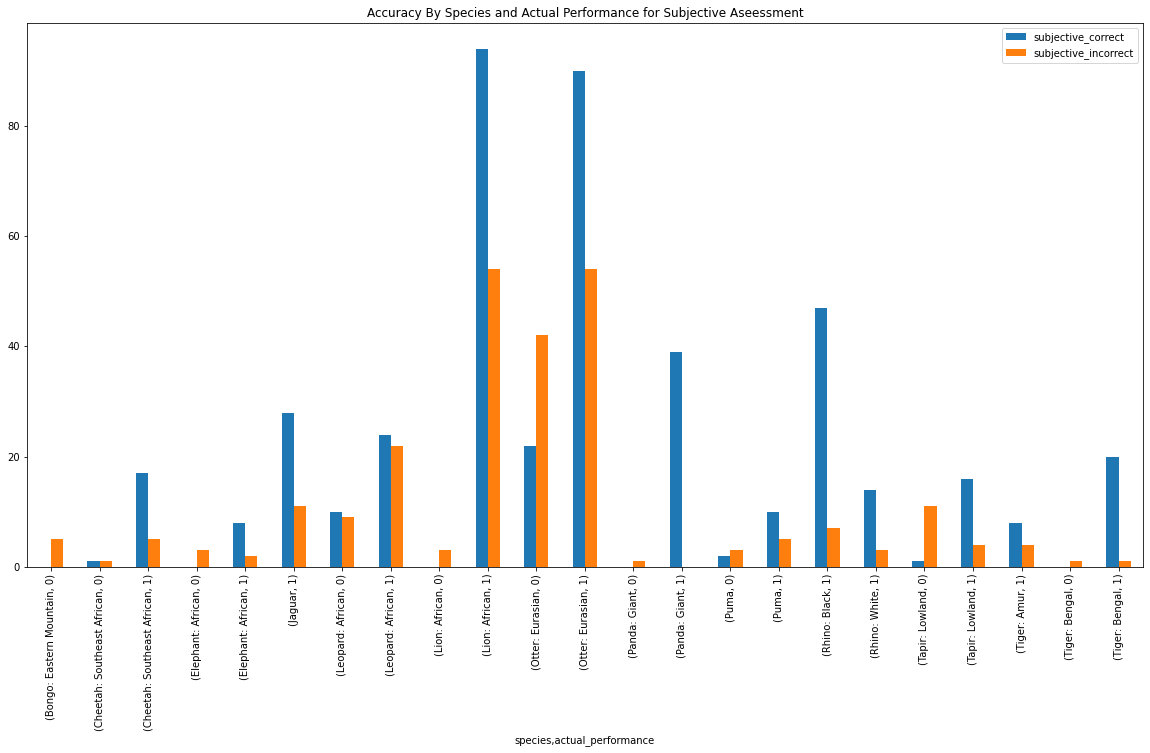

In [ ]:
subj_accuracy_by_species_and_actual_perf.plot(kind = 'bar', figsize=(20,10))
plt.title('Accuracy By Species and Actual Performance for Subjective Aseessment')
plt.show()

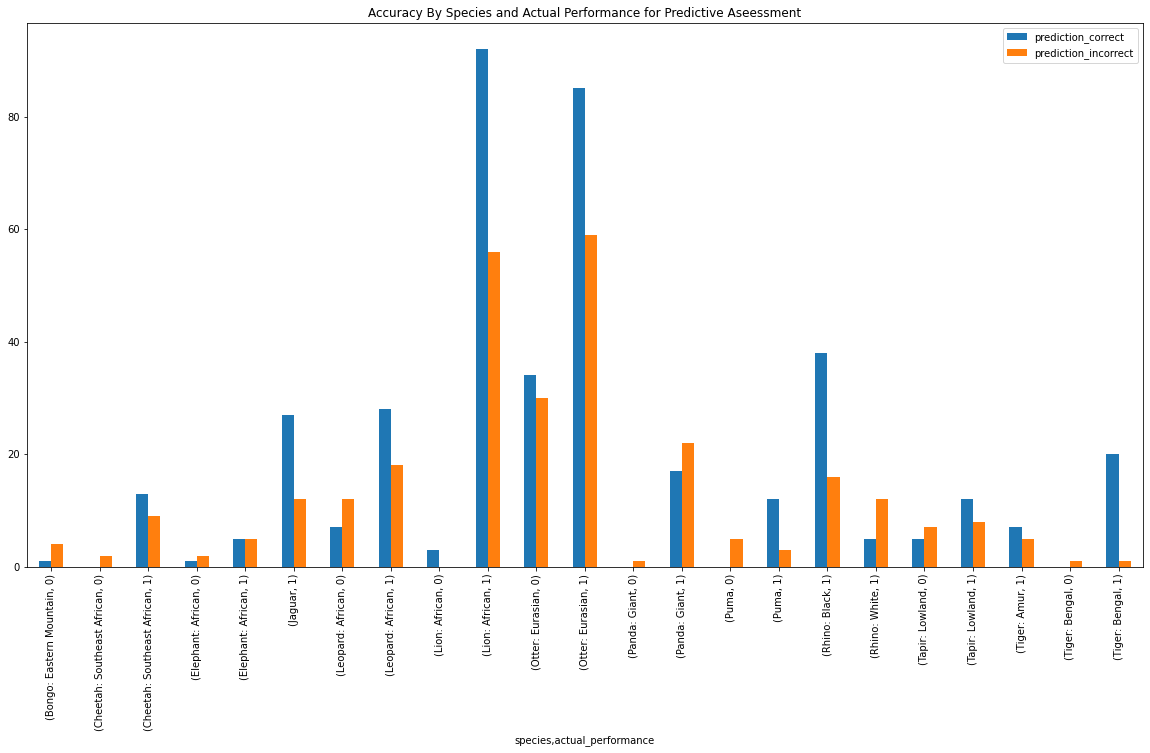

In [ ]:
pred_accuracy_by_species_and_actual_perf.plot(kind = 'bar', figsize=(20,10))
plt.title('Accuracy By Species and Actual Performance for Predictive Aseessment')
plt.show()